In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import random

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    classification_report
)
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, GRU, Dropout

import warnings

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
file_path = r"/content/Spotify_dataset.csv"
df = pd.read_csv(file_path)
df.head(10)

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE
5,The player controls sometimes disappear for no...,NEGATIVE
6,I love the selection and the lyrics are provid...,POSITIVE
7,Still extremely slow when changing storage to ...,NEGATIVE
8,It's a great app and the best mp3 music app I ...,POSITIVE
9,"I'm deleting this app, for the following reaso...",NEGATIVE


In [8]:
df.iloc[4,1]

'NEGATIVE'

In [9]:
print(f'Number of samples: {df.shape[0]}\nNumber of features: {df.shape[1]}')

Number of samples: 52702
Number of features: 2


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


In [11]:
patterns = [
    "I use Spotify {frequency}; it’s {adjective}.",
    "The app {performance} for {purpose}.",
    "Spotify is {adjective} for {audience}.",
    "It’s {adjective}; the app {fulfillment}.",
    "The {feature} is {adjective}; it {fulfillment}.",
    "I use Spotify for {activity}; it’s {adjective}.",
    "The app is {adjective} but {improvement}.",
    "Sound quality is {adjective}; it works for me.",
    "Spotify is {adjective}; it {fulfillment}.",
    "The {aspect} is {adjective} but not {expectation}."
]

word_pools = {
    "frequency": ["occasionally", "sometimes", "rarely", "often", "frequently"],
    "adjective": ["decent", "fine", "acceptable", "okay", "average"],
    "performance": ["works fine", "functions well", "runs smoothly", "is okay"],
    "purpose": ["streaming music", "general use", "music discovery"],
    "audience": ["casual listeners", "basic needs", "everyday users"],
    "fulfillment": ["does its job", "meets expectations", "serves its purpose"],
    "feature": ["playlist variety", "music library", "interface"],
    "activity": ["basic streaming", "casual listening", "background music"],
    "aspect": ["overall experience", "app design", "service"],
    "improvement": ["nothing special", "could improve", "lacks uniqueness"],
    "expectation": ["exceptional", "remarkable", "outstanding"]
}

def generate_reviews(n=15000):
    reviews = []
    for _ in range(n):
        pattern = random.choice(patterns)
        review = pattern.format(
            frequency=random.choice(word_pools["frequency"]),
            adjective=random.choice(word_pools["adjective"]),
            performance=random.choice(word_pools["performance"]),
            purpose=random.choice(word_pools["purpose"]),
            audience=random.choice(word_pools["audience"]),
            fulfillment=random.choice(word_pools["fulfillment"]),
            feature=random.choice(word_pools["feature"]),
            activity=random.choice(word_pools["activity"]),
            aspect=random.choice(word_pools["aspect"]),
            improvement=random.choice(word_pools["improvement"]),
            expectation=random.choice(word_pools["expectation"])
        )
        reviews.append({"Review": review, "label": "NEUTRAL"})
    return reviews

# Generate 1000 reviews
neutral_reviews = generate_reviews(15000)

neutral_reviews[:5]

[{'Review': 'Sound quality is acceptable; it works for me.',
  'label': 'NEUTRAL'},
 {'Review': 'I use Spotify for basic streaming; it’s fine.',
  'label': 'NEUTRAL'},
 {'Review': 'The overall experience is acceptable but not exceptional.',
  'label': 'NEUTRAL'},
 {'Review': 'Spotify is acceptable; it meets expectations.',
  'label': 'NEUTRAL'},
 {'Review': 'The app is okay but nothing special.', 'label': 'NEUTRAL'}]

In [12]:
neutral_df = pd.DataFrame(neutral_reviews)

updated_dataset = pd.concat([df.iloc[:4], neutral_df, df.iloc[4:]], ignore_index=True)

updated_dataset.iloc[0:10]

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Sound quality is acceptable; it works for me.,NEUTRAL
5,I use Spotify for basic streaming; it’s fine.,NEUTRAL
6,The overall experience is acceptable but not e...,NEUTRAL
7,Spotify is acceptable; it meets expectations.,NEUTRAL
8,The app is okay but nothing special.,NEUTRAL
9,I use Spotify for casual listening; it’s fine.,NEUTRAL


In [13]:
updated_dataset.to_csv('updated_dataset.csv', index=False)


In [14]:
updated_dataset.iloc[4,1]

'NEUTRAL'

In [15]:
print(f'Number of samples: {updated_dataset.shape[0]}\nNumber of features: {updated_dataset.shape[1]}')

Number of samples: 67702
Number of features: 2


In [16]:
updated_dataset['label'].isna().sum()

0

In [17]:
updated_dataset['Review'].isna().sum()

16

In [18]:
cleaned_dataset = updated_dataset.dropna(subset=['Review']).reset_index(drop=True)

In [19]:
cleaned_dataset = updated_dataset.dropna(subset=['label']).reset_index(drop=True)

In [20]:
cleaned_dataset['Review'].isna().sum()

16

In [21]:
print(f'Number of samples after cleaning: {cleaned_dataset.shape[0]}\nNumber of features: {cleaned_dataset.shape[1]}')
print(f'Number of null values in "Review" column: {cleaned_dataset["Review"].isna().sum()}')

Number of samples after cleaning: 67702
Number of features: 2
Number of null values in "Review" column: 16


In [22]:
updated_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67702 entries, 0 to 67701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  67686 non-null  object
 1   label   67702 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [23]:
updated_dataset.head()

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Sound quality is acceptable; it works for me.,NEUTRAL


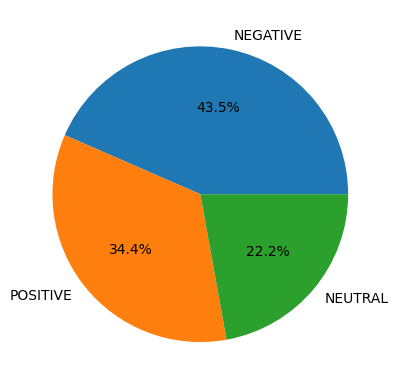

In [24]:
import matplotlib.pyplot as plt
label_counts = updated_dataset['label'].value_counts(dropna=False)
labels = label_counts.index
plt.pie(label_counts, labels=labels, autopct='%1.1f%%')
plt.show()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(updated_dataset, updated_dataset['label'], test_size=0.10, random_state=42)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [27]:
def Classification_model(df1, label, binary=False, model=MultinomialNB):
    df1 = df1.dropna(subset=[label])
    X_train, X_test, y_train, y_test = train_test_split(df1.drop(columns=[label]), df1[label], test_size=0.10, random_state=42)
    X_train = X_train.dropna(subset=['Review'])
    X_test = X_test.dropna(subset=['Review'])
    y_train = y_train[X_train.index]
    y_test = y_test[X_test.index]
    vectorizer = CountVectorizer(binary=binary)
    X_train_vec = vectorizer.fit_transform(X_train['Review'])
    X_test_vec = vectorizer.transform(X_test['Review'])
    clf = model()
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    result = {
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1": f1,
        "Confusion Matrix": conf_matrix
    }
    return result


In [28]:
updated_dataset.dropna(subset=['Review'], inplace=True)

In [29]:
for model in (MultinomialNB, LogisticRegression):
    result = Classification_model(updated_dataset, 'label', model=model)
    print(f"Model: {model.__name__}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Recall: {result['Recall']}")
    print(f"Precision: {result['Precision']}")
    print(f"F1: {result['F1']}")
    print("Confusion Matrix:")
    print(result['Confusion Matrix'])
    print("-" * 20)


Model: MultinomialNB
Accuracy: 0.8965873836608066
Recall: 0.8965873836608066
Precision: 0.8964567488869507
F1: 0.8965162398997356
Confusion Matrix:
[[2585    0  353]
 [   0 1466    0]
 [ 337   10 2018]]
--------------------
Model: LogisticRegression
Accuracy: 0.9153493869109174
Recall: 0.9153493869109174
Precision: 0.9154249889089554
F1: 0.9153727404994753
Confusion Matrix:
[[2639    2  297]
 [   0 1466    0]
 [ 274    0 2091]]
--------------------


In [30]:
updated_dataset.isnull().sum()

,0
Review,0
label,0


In [31]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [33]:
vocab_size = 10000
max_length = 500
X_train['Review'] = X_train['Review'].astype(str).fillna('')
X_test['Review'] = X_test['Review'].astype(str).fillna('')

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train['Review'])

X_train_sequences = tokenizer.texts_to_sequences(X_train['Review'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['Review'])

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = Sequential()
model.add(Embedding(vocab_size, 16, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer with appropriate number of units

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

model.fit(X_train_padded, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test_padded, y_test_encoded),callbacks=[early_stopping_cb])

loss, accuracy = model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4848 - loss: 0.9986 - val_accuracy: 0.6915 - val_loss: 0.6867
Epoch 2/50
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7327 - loss: 0.6028 - val_accuracy: 0.7472 - val_loss: 0.5028
Epoch 3/50
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7950 - loss: 0.4548 - val_accuracy: 0.8225 - val_loss: 0.3978
Epoch 4/50
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8208 - loss: 0.4038 - val_accuracy: 0.8564 - val_loss: 0.3401
Epoch 5/50
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8557 - loss: 0.3419 - val_accuracy: 0.8697 - val_loss: 0.3180
Epoch 6/50
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8739 - loss: 0.3076 - val_accuracy: 0.8780 - val_loss: 0.2833
Epoch 7/50
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8830 - loss: 0.2893 - val_accuracy: 0.8962 - val_loss: 0.2636
Epoch 8/50
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8870 - loss: 0.2753 - 

In [34]:
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.9174420237541199


In [35]:
vocab_size = 10000
max_length = 500

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train['Review'])

X_train_sequences = tokenizer.texts_to_sequences(X_train['Review'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['Review'])

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

vectorize_layer = tokenizer


tf.random.set_seed(42)
seq_length = len(vectorize_layer.word_index) + 1
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=seq_length, output_dim=16),
    tf.keras.layers.SimpleRNN(128, return_sequences=False),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)


BATCH_SIZE = 32
BUFFER_SIZE = 10000
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train_encoded))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_test_padded, y_test_encoded))
valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=True)


history = model.fit(train_dataset, validation_data=valid_dataset, epochs=50, callbacks=[early_stopping_cb])

Epoch 1/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 112s 55ms/step - accuracy: 0.4173 - loss: 1.0736 - val_accuracy: 0.4245 - val_loss: 1.0823
Epoch 2/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 137s 54ms/step - accuracy: 0.4190 - loss: 1.0719 - val_accuracy: 0.4185 - val_loss: 1.0721
Epoch 3/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 102s 53ms/step - accuracy: 0.4255 - loss: 1.0662 - val_accuracy: 0.4291 - val_loss: 1.0640
Epoch 4/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 141s 53ms/step - accuracy: 0.4356 - loss: 1.0611 - val_accuracy: 0.4378 - val_loss: 1.0683
Epoch 5/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 142s 53ms/step - accuracy: 0.4374 - loss: 1.0594 - val_accuracy: 0.4159 - val_loss: 1.0798
Epoch 6/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 100s 53ms/step - accuracy: 0.4286 - loss: 1.0664 - val_accuracy: 0.4317 - val_loss: 1.0588
Epoch 7/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 142s 52ms/step - accuracy: 0.4252 - loss: 1.0574 - val_accuracy: 0.4317 - val_loss: 1.0667
Epoch 8/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 143s 53ms/step - accuracy: 

In [39]:
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.4514842629432678


In [36]:
vocab_size = 10000
max_length = 500

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train['Review'])

X_train_sequences = tokenizer.texts_to_sequences(X_train['Review'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['Review'])

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

vectorize_layer = tokenizer

tf.random.set_seed(42)
seq_length = len(vectorize_layer.word_index) + 1
updated_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=seq_length, output_dim=32),
    tf.keras.layers.GRU(128, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation="softmax")
])
updated_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

BATCH_SIZE = 32
BUFFER_SIZE = 10000
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train_encoded))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_test_padded, y_test_encoded))
valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=True)

history = updated_model.fit(train_dataset, validation_data=valid_dataset, epochs=50, callbacks=[early_stopping_cb])

Epoch 1/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - accuracy: 0.4360 - loss: 1.0642 - val_accuracy: 0.4317 - val_loss: 1.0666
Epoch 2/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.4319 - loss: 1.0647 - val_accuracy: 0.4317 - val_loss: 1.0638
Epoch 3/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.4355 - loss: 1.0631 - val_accuracy: 0.4317 - val_loss: 1.0638
Epoch 4/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.4380 - loss: 1.0626 - val_accuracy: 0.4317 - val_loss: 1.0648
Epoch 5/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.4356 - loss: 1.0636 - val_accuracy: 0.4317 - val_loss: 1.0643
Epoch 6/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.4357 - loss: 1.0631 - val_accuracy: 0.4317 - val_loss: 1.0637


In [37]:
loss, accuracy = updated_model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.4313986003398895


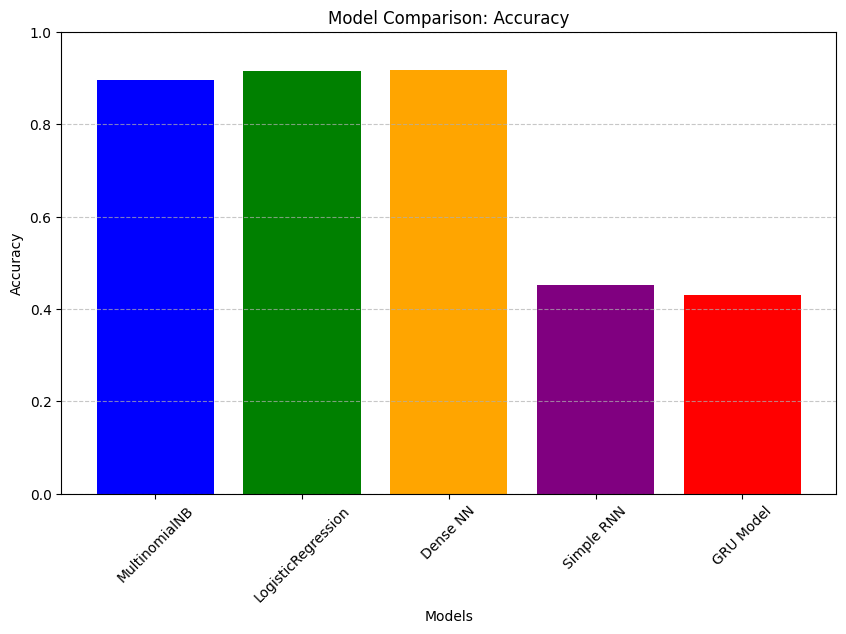

In [46]:
import matplotlib.pyplot as plt

model_names = [
    "MultinomialNB",
    "LogisticRegression",
    "Dense NN",
    "Simple RNN",
    "GRU Model"
]

accuracies = [
    0.8965,  # Replace with the actual accuracy for MultinomialNB
    0.9153, # Replace with the actual accuracy for LogisticRegression
    0.9174,  # Replace with the actual accuracy for Dense Neural Network
    0.4514, # Replace with the actual accuracy for Simple RNN
    0.4313   # Replace with the actual accuracy for GRU Model
]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'purple', 'red'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison: Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()